In [5]:
from BioPandas import pandas as pd
from Bio import SeqIO
import gzip
import numpy as np

# Sample files used

In [7]:
gbk = 'test-data/GCF_000013425.1.gbk.gz'
fasta = 'test-data/random_sequences.fasta.gz'

# Fasta to Pandas DataFrame example

In [11]:
fasta_df = pd.read_seq(fasta, format='fasta')
fasta_df.head(3)

,_per_letter_annotations,_seq,annotations,dbxrefs,description,features,id,name
0,{},"(C, G, A, T, A, T, T, C, G, A, T, C, C, G, C, ...",{},[],FWIRNKE01DKIF6 rank=0000177 x=1346.0 y=2772.0 ...,[],FWIRNKE01DKIF6,FWIRNKE01DKIF6
1,{},"(G, C, G, A, G, C, A, G, C, A, A, T, C, A, T, ...",{},[],FWIRNKE01CDBE3 rank=0000320 x=854.0 y=2685.0 l...,[],FWIRNKE01CDBE3,FWIRNKE01CDBE3
2,{},"(C, G, A, G, C, A, G, C, A, C, A, T, C, A, T, ...",{},[],FWIRNKE01BKZJJ rank=0000535 x=531.0 y=3933.0 l...,[],FWIRNKE01BKZJJ,FWIRNKE01BKZJJ


# You can also import seqrecords directly from BioPythons parsing output.

In [5]:
with gzip.open(fasta, "rt") as handle:
    seqrecords = SeqIO.parse(handle, format='fasta')
    fasta_df = pd.DataFrame.from_seqrecords(seqrecords)
fasta_df.head(3)

,_per_letter_annotations,_seq,annotations,dbxrefs,description,features,id,name
0,{},"(C, G, A, T, A, T, T, C, G, A, T, C, C, G, C, ...",{},[],FWIRNKE01DKIF6 rank=0000177 x=1346.0 y=2772.0 ...,[],FWIRNKE01DKIF6,FWIRNKE01DKIF6
1,{},"(G, C, G, A, G, C, A, G, C, A, A, T, C, A, T, ...",{},[],FWIRNKE01CDBE3 rank=0000320 x=854.0 y=2685.0 l...,[],FWIRNKE01CDBE3,FWIRNKE01CDBE3
2,{},"(C, G, A, G, C, A, G, C, A, C, A, T, C, A, T, ...",{},[],FWIRNKE01BKZJJ rank=0000535 x=531.0 y=3933.0 l...,[],FWIRNKE01BKZJJ,FWIRNKE01BKZJJ


# Search description with little effort!

In [6]:
# I want all ranks of a certain number 
fasta_df[fasta_df['description'].str.contains('rank=0000177')]

,_per_letter_annotations,_seq,annotations,dbxrefs,description,features,id,name
0,{},"(C, G, A, T, A, T, T, C, G, A, T, C, C, G, C, ...",{},[],FWIRNKE01DKIF6 rank=0000177 x=1346.0 y=2772.0 ...,[],FWIRNKE01DKIF6,FWIRNKE01DKIF6


# Better view of the layout for a single row

In [7]:
fasta_df.head(1).to_dict('records')

[{'_per_letter_annotations': {},
  '_seq': Seq('CGATATTCGATCCGCATCGCTGCCCTACCCGTGGAGTGCCTCCCTCGGNGCAG', SingleLetterAlphabet()),
  'annotations': {},
  'dbxrefs': [],
  'description': 'FWIRNKE01DKIF6 rank=0000177 x=1346.0 y=2772.0 length=53',
  'features': [],
  'id': 'FWIRNKE01DKIF6',
  'name': 'FWIRNKE01DKIF6'}]

# GenBank to Pandas DataFrame example

In [8]:
gbk_df = pd.read_seq(gbk, format='genbank')
gbk_df.head(3)

,EC_number,_per_letter_annotations,_seq,accessions,codon_start,comment,contig,data_file_division,date,db_xref,...,references,sequence_version,source,strain,sub_species,taxonomy,topology,transl_table,translation,type
0,NaN,{},"(C, G, A, T, T, A, A, A, G, A, T, A, G, A, A, ...",[NC_007795],NaN,REVIEWED REFSEQ: This record has been curated ...,join(CP000253.1:1..2821361),CON,03-AUG-2016,[taxon:93061],...,"[location: [0:2821361]\nauthors: Gillaspy,A.F....",1,Staphylococcus aureus subsp. aureus NCTC 8325,[NCTC 8325],[aureus],"[Bacteria, Firmicutes, Bacilli, Bacillales, St...",circular,NaN,NaN,source
1,NaN,{},"(C, G, A, T, T, A, A, A, G, A, T, A, G, A, A, ...",[NC_007795],NaN,REVIEWED REFSEQ: This record has been curated ...,join(CP000253.1:1..2821361),CON,03-AUG-2016,[GeneID:3919798],...,"[location: [0:2821361]\nauthors: Gillaspy,A.F....",1,Staphylococcus aureus subsp. aureus NCTC 8325,NaN,NaN,"[Bacteria, Firmicutes, Bacilli, Bacillales, St...",circular,NaN,NaN,gene
2,NaN,{},"(C, G, A, T, T, A, A, A, G, A, T, A, G, A, A, ...",[NC_007795],[1],REVIEWED REFSEQ: This record has been curated ...,join(CP000253.1:1..2821361),CON,03-AUG-2016,[GeneID:3919798],...,"[location: [0:2821361]\nauthors: Gillaspy,A.F....",1,Staphylococcus aureus subsp. aureus NCTC 8325,NaN,NaN,"[Bacteria, Firmicutes, Bacilli, Bacillales, St...",circular,[11],[MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSS...,CDS


# See all the possible columns of meta data

In [9]:
gbk_df.columns

Index(['EC_number', '_per_letter_annotations', '_seq', 'accessions',
       'codon_start', 'comment', 'contig', 'data_file_division', 'date',
       'db_xref', 'dbxrefs', 'description', 'experiment', 'gene',
       'gene_synonym', 'id', 'keywords', 'location', 'locus_tag', 'mol_type',
       'molecule_type', 'name', 'note', 'organism', 'product', 'protein_id',
       'pseudo', 'pseudogene', 'references', 'sequence_version', 'source',
       'strain', 'sub_species', 'taxonomy', 'topology', 'transl_table',
       'translation', 'type'],
      dtype='object')

# Seach for only rows of type CDS

In [10]:
cds = gbk_df[gbk_df.type == 'CDS']
gene = gbk_df[gbk_df.type == 'gene']
print('Genome has CDS count:', cds.shape)
print('Genome has GENE count:', gene.shape)

Genome has CDS count: (2767, 38)
Genome has GENE count: (2872, 38)


In [11]:
cds.head(3)

,EC_number,_per_letter_annotations,_seq,accessions,codon_start,comment,contig,data_file_division,date,db_xref,...,references,sequence_version,source,strain,sub_species,taxonomy,topology,transl_table,translation,type
2,NaN,{},"(C, G, A, T, T, A, A, A, G, A, T, A, G, A, A, ...",[NC_007795],[1],REVIEWED REFSEQ: This record has been curated ...,join(CP000253.1:1..2821361),CON,03-AUG-2016,[GeneID:3919798],...,"[location: [0:2821361]\nauthors: Gillaspy,A.F....",1,Staphylococcus aureus subsp. aureus NCTC 8325,NaN,NaN,"[Bacteria, Firmicutes, Bacilli, Bacillales, St...",circular,[11],[MSEKEIWEKVLEIAQEKLSAVSYSTFLKDTELYTIKDGEAIVLSS...,CDS
4,[2.7.7.7],{},"(C, G, A, T, T, A, A, A, G, A, T, A, G, A, A, ...",[NC_007795],[1],REVIEWED REFSEQ: This record has been curated ...,join(CP000253.1:1..2821361),CON,03-AUG-2016,[GeneID:3919799],...,"[location: [0:2821361]\nauthors: Gillaspy,A.F....",1,Staphylococcus aureus subsp. aureus NCTC 8325,NaN,NaN,"[Bacteria, Firmicutes, Bacilli, Bacillales, St...",circular,[11],[MMEFTIKRDYFITQLNDTLKAISPRTTLPILTGIKIDAKEHEVIL...,CDS
6,NaN,{},"(C, G, A, T, T, A, A, A, G, A, T, A, G, A, A, ...",[NC_007795],[1],REVIEWED REFSEQ: This record has been curated ...,join(CP000253.1:1..2821361),CON,03-AUG-2016,[GeneID:3919176],...,"[location: [0:2821361]\nauthors: Gillaspy,A.F....",1,Staphylococcus aureus subsp. aureus NCTC 8325,NaN,NaN,"[Bacteria, Firmicutes, Bacilli, Bacillales, St...",circular,[11],[MIILVQEVVVEGDINLGQFLKTEGIIESGGQAKWFLQDVEVLING...,CDS


# Better view of the layout for a single row

In [12]:
cds.head(1).to_dict('records')

[{'EC_number': nan,
  '_per_letter_annotations': {},
  '_seq': Seq('CGATTAAAGATAGAAATACACGATGCGAGCAATCAAATTTCATAACATCACCAT...TAT', IUPACAmbiguousDNA()),
  'accessions': ['NC_007795'],
  'codon_start': ['1'],
  'comment': 'REVIEWED REFSEQ: This record has been curated by NCBI staff. The\nreference sequence was derived from CP000253.\nRefSeq Category: Reference Genome\n            UPR: UniProt Genome\nStaphylococcus aureus subsp. aureus NCTC 8325 is available from\nwww.narsa.net.\nCOMPLETENESS: full length.',
  'contig': 'join(CP000253.1:1..2821361)',
  'data_file_division': 'CON',
  'date': '03-AUG-2016',
  'db_xref': ['GeneID:3919798'],
  'dbxrefs': ['BioProject:PRJNA57795', 'Assembly:GCF_000013425.1'],
  'description': 'Staphylococcus aureus subsp. aureus NCTC 8325 chromosome, complete genome',
  'experiment': nan,
  'gene': ['dnaA'],
  'gene_synonym': nan,
  'id': 'NC_007795.1',
  'keywords': ['RefSeq'],
  'location': FeatureLocation(ExactPosition(516), ExactPosition(1878), strand=1)

------

# Machine Learning Example Application

### For simplicity of this example we will pretend we have a large sample set, but really we just using the single genbank genome. The follow will create the feature table we can use for a simple Sequential model.
1. Sample the first 4 genes
2. Given them random mutation value from 0 to 20
3. Give each mutation a random "observed in healthy patient"

In [13]:
# Sample for the first 4 genes
genes = [gene[0] for gene in gbk_df[(gbk_df.type == 'gene') & ~gbk_df.gene.isna()]['gene'][:4].values]
genes

['dnaA', 'recF', 'rplI', 'argJ']

In [27]:
genes = ['dnaA', 'recF', 'rplI', 'argJ']

In [28]:
# Create fake observed mutation rates for target genomes compared to a reference genome
mutation_array = lambda : list(np.random.uniform(low=0, high=20, size=(1, 100))[0])
observed_gene_mutation_per_genome = pd.DataFrame.from_dict({gene:mutation_array() for gene in genes})
observed_gene_mutation_per_genome.head(3)

,dnaA,recF,rplI,argJ
0,8.615931,17.906514,14.575177,2.743147
1,4.034300,1.794926,11.473486,15.008555
2,19.376403,2.339961,3.557232,9.556185


In [29]:
# Give a 0 or 1 to show if a patient has the fake disease
# We a biased 30 percent with disease  
patients = np.zeros(100)
patients[:30] = 1
np.random.shuffle(patients)

observed_gene_mutation_per_genome['fake_disease'] = list(patients)
observed_gene_mutation_per_genome.head(10)

,dnaA,recF,rplI,argJ,fake_disease
0,8.615931,17.906514,14.575177,2.743147,1.0
1,4.034300,1.794926,11.473486,15.008555,0.0
2,19.376403,2.339961,3.557232,9.556185,0.0
3,5.283454,0.395019,7.270980,18.873140,0.0
4,12.732603,14.664262,11.857449,9.892937,0.0
5,15.451532,0.991480,11.116211,0.759984,0.0
6,9.783260,17.743193,12.138172,9.841209,0.0
7,13.850767,13.739428,17.460336,8.261470,1.0
8,18.238783,3.425863,13.880310,4.257181,0.0
9,12.593506,19.079922,15.292988,3.474469,0.0


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score

In [31]:
df = observed_gene_mutation_per_genome
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:4], df['fake_disease'],
                                                    test_size = 0.33, random_state = 100)

# Create general sequential model with 4 layers  

In [32]:
model = Sequential()

model.add(Dense(4, activation = 'relu')) # 4 for just random guessing
model.add(Dense(4, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
model.add(Dense(1)) # just want healthy status; hence final layer is 1

model.compile(optimizer='rmsprop', loss='mse') # mean squared error for sanity checking

In [35]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 1)
model.fit(
    x = X_train.to_numpy().astype('float32'), # float32 to save memory and runtime; we dont need 64 bits anyway
    y = y_train.to_numpy().astype('float32'), 
    verbose = 1, # 0 if you dont want to see the print out
    epochs = 100, # number of training intervals 
    # callbacks = [early_stop], # cant used validation set to have an educated stop due to data set being too small :(
    # validation_data=(X_test.astype('float32'), y_test.astype('float32')), # data too small to use as a validator
)

Epoch 1/100
3/3 [==============================] - 0s 1ms/step - loss: 2.8593
Epoch 2/100
3/3 [==============================] - 0s 981us/step - loss: 1.8085
Epoch 3/100
3/3 [==============================] - 0s 787us/step - loss: 1.3662
Epoch 4/100
3/3 [==============================] - 0s 735us/step - loss: 1.1024
Epoch 5/100
3/3 [==============================] - 0s 787us/step - loss: 0.8755
Epoch 6/100
3/3 [==============================] - 0s 1ms/step - loss: 0.7448
Epoch 7/100
3/3 [==============================] - 0s 947us/step - loss: 0.6349
Epoch 8/100
3/3 [==============================] - 0s 851us/step - loss: 0.5505
Epoch 9/100
3/3 [==============================] - 0s 889us/step - loss: 0.4751
Epoch 10/100
3/3 [==============================] - 0s 1ms/step - loss: 0.4273
Epoch 11/100
3/3 [==============================] - 0s 1ms/step - loss: 0.3824
Epoch 12/100
3/3 [==============================] - 0s 1ms/step - loss: 0.3573
Epoch 13/100
3/3 [=============================

# Check how well your model was built

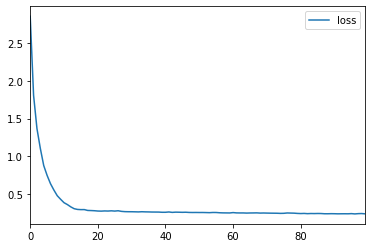

In [36]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [ ]:
model # Thats exciting! This is also a word of caution that you can make a model from anything. 

--------

# Extra Notes

In [ ]:
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC

# Creating a BioPython seq from scratch

In [ ]:
seq = Seq('ATGCATGATGATGATGATGATAG', alphabet=IUPAC.Alphabet.single_letter_alphabet)
seq

## You can create a simple dataframe as such

In [ ]:
pd.DataFrame([{'_seq': seq}])._seq 